── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 0.1.2 ──

✔ broom     0.7.5      ✔ recipes   0.1.15
✔ dials     0.0.9      ✔ rsample   0.0.9 
✔ infer     0.5.4      ✔ tune      0.1.3 
✔ modeldata 0.1.0      ✔ workflows 0.2.2 
✔ parsnip   0.1.5      ✔ yardstick 0.0.8 

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::

kommune_name,n
<chr>,<int>
Oslo,2394
Trondheim,918
Bergen,900
Stavanger,805
Kristiansand,546
Sandnes,394
Haugesund,390
Kristiansund,304
Arendal,291



Call:
stats::lm(formula = tot_price ~ ., data = data)

Residuals:
      Min        1Q    Median        3Q       Max 
-77391333   -882492   -275568    456682  63722291 

Coefficients:
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     5.935e+06  2.133e+06   2.782 0.005411 ** 
sqm                             8.122e+03  1.727e+02  47.025  < 2e-16 ***
expense                        -1.095e+02  8.215e+00 -13.332  < 2e-16 ***
lat                            -6.890e+04  3.604e+04  -1.912 0.055925 .  
lng                             5.682e+03  2.666e+04   0.213 0.831227    
kommune_nameAlta                1.567e+06  5.031e+05   3.114 0.001847 ** 
kommune_nameAndøy              -7.580e+05  6.258e+05  -1.211 0.225858    
kommune_nameArendal            -2.838e+05  4.095e+05  -0.693 0.488239    
kommune_nameAsker               4.262e+06  4.252e+05  10.022  < 2e-16 ***
kommune_nameAskim               5.271e+05  4.883e+05   1.079 0.280436    
ko

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
mape,standard,38.10883


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 13 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


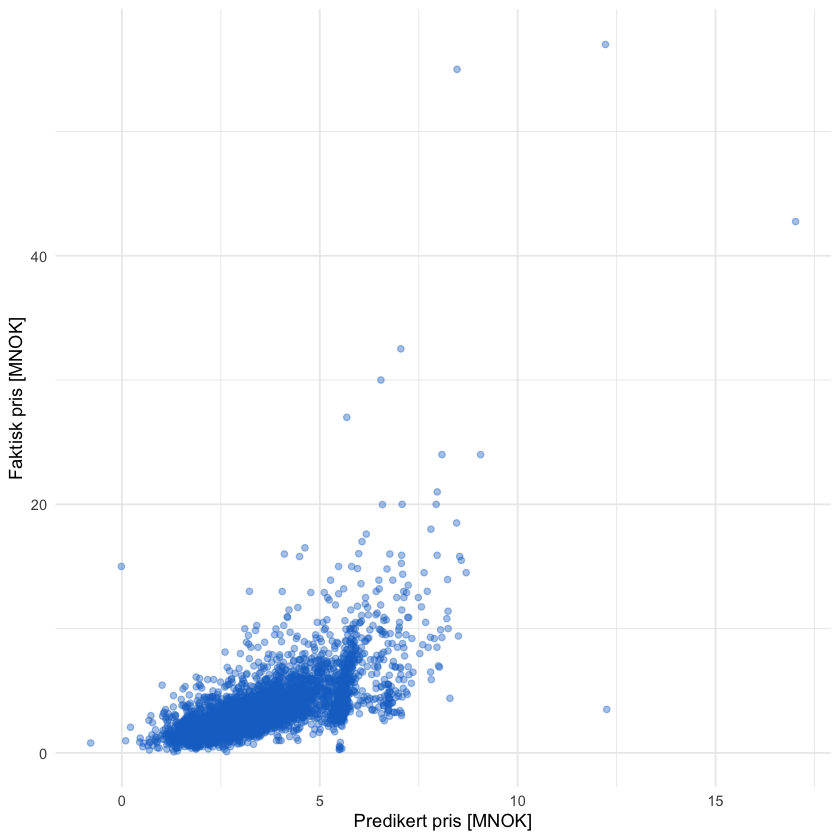

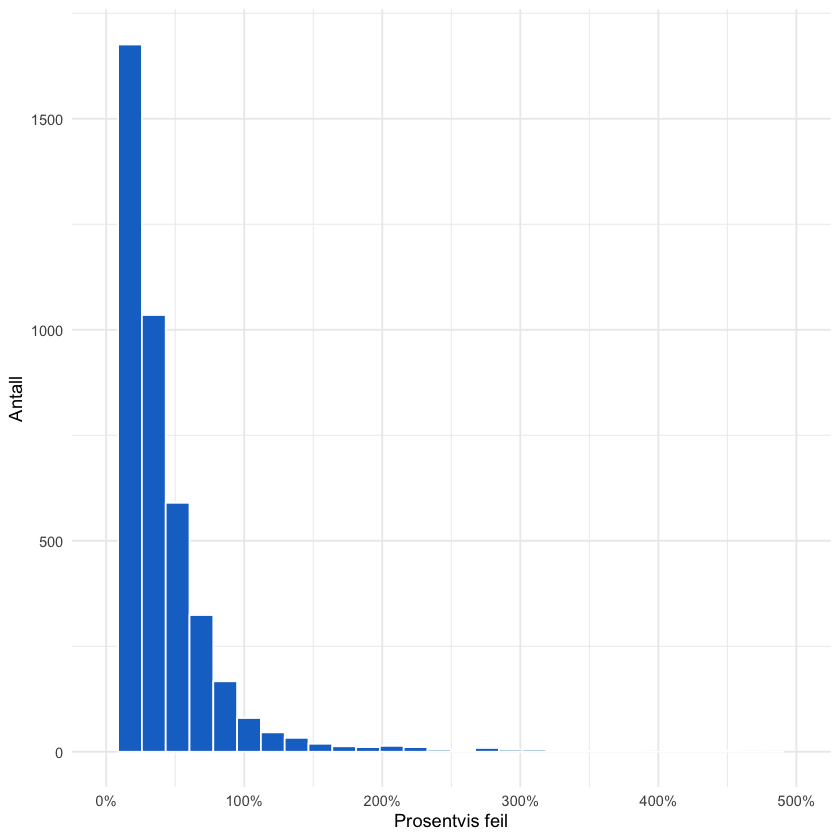

In [1]:
################### #
# Attach packages ----
################### #

library(tidyverse)
library(tidymodels)
library(readxl)

#################### #
# Read data and mutate: ----
# Include latitude, longitude and municipality in the dataset 
# - Keep only the 220 most common municipalities in the dataset
#################### #

houses_raw <- read_excel("temp/houses.xlsx")

houses_raw %>% 
  count(kommune_name, sort = TRUE) %>% 
  filter(n >= 15)

houses <- houses_raw %>%
  select(id, sqm, expense, tot_price, lat, lng, kommune_name) %>% 
  mutate(kommune_name = fct_lump_n(kommune_name, 220))

################### #
# Split data using the rsample package ----
# Set seed in order to make the analysis reproducible 
################### #

set.seed(42)

split     <- initial_split(houses, prop = 3/4)
train_raw <- training(split)
test_raw  <- testing(split)

train     <- train_raw %>% 
  select(-id)

test      <- test_raw %>% 
  select(-id)

################### #
# Create a linear model ----
################### #

model <- linear_reg() %>% 
  set_engine("lm") %>% 
  fit(tot_price ~ ., data = train)

################### #
# View summary of fit regression line
################### #

summary(model$fit)

################### #
# Use the linear model to make predictions on test data
################### #

model_preds <- 
  predict(model, test) %>% 
  bind_cols(test_raw) %>% 
  rename(estimate     = .pred, 
         truth        = tot_price) %>% 
  mutate(abs_dev      = abs(truth - estimate),
         abs_dev_perc = abs_dev/truth)

#################### #
# Use the package yardstick to get evaluation of the model
#################### #

mape(data = model_preds, truth = truth, estimate = estimate)

##################################### #
# Plot predictions ----
##################################### #

model_preds %>% 
  ggplot(aes(x = estimate/1000000, y = truth/1000000)) +
  geom_point(color = "dodgerblue3", alpha = 0.4) +
  labs(x = "Predikert pris [MNOK]",
       y = "Faktisk pris [MNOK]") +
  theme_minimal()

model_preds %>%
  ggplot(aes(x = abs_dev_perc)) +
  geom_histogram(fill = "dodgerblue3", color = "white") +
  labs(x = "Prosentvis feil",
       y = "Antall") +
  scale_x_continuous(limits = c(0,5), labels = scales::percent) +
  theme_minimal()

